In [22]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data_dir = "/home/abir/Repos/real-time-face-mask-detection/data"

In [32]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor()
    ]),

    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, "Train"), transform=image_transforms["train"])
val_data = datasets.ImageFolder(os.path.join(data_dir, "Validation"), transform=image_transforms["val"])
test_data = datasets.ImageFolder(os.path.join(data_dir, "Test"), transform=image_transforms["val"])

# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

class_names = train_data.classes
print("Classes:", class_names)

FileNotFoundError: [Errno 2] No such file or directory: '/real-time-face-mask-detection/data/Train'

In [25]:
print(f"Size of the traing data is {len(train_data)}")
print(f"Size of the validation data is {len(val_data)}")
print(f"Size of the testing data is {len(test_data)}")

Size of the traing data is 17450
Size of the validation data is 800
Size of the testing data is 992


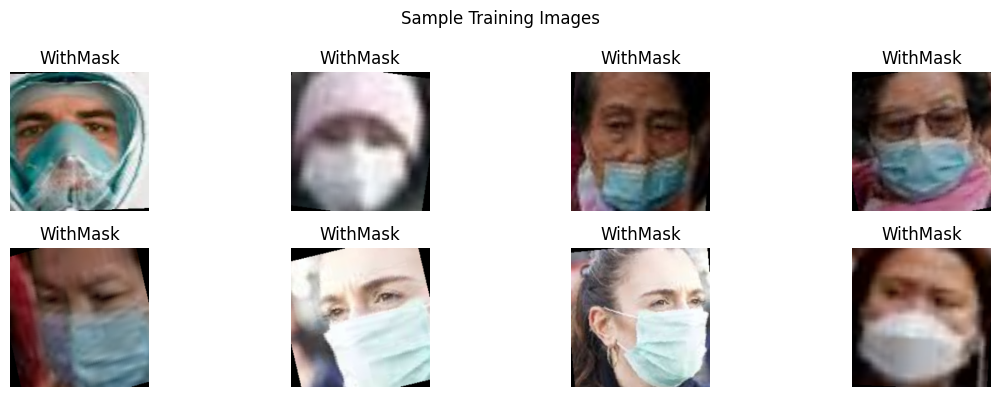

In [26]:
def show_samples(dataset, title):
    fig, axes = plt.subplots(2, 4, figsize=(12, 4))
    for i, ax in enumerate(axes.flatten()):
        img, label = dataset[i]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_data, "Sample Training Images")